# Install requirements and prepare environment

In [1]:
!pip install gdown

In [3]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from time import time
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
import os
import pandas as pd
import gc
import random
import pickle
import gdown
import json
import string
from zipfile import ZipFile
from torch.nn.functional import cosine_similarity
from tabulate import tabulate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

In [7]:
url = "https://drive.google.com/file/d/1YLhhCTM9FH5lSGdyfZFjb1ERMui6Wt3B/view?usp=sharing"
output = "image_model_dataset.pkl"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1YLhhCTM9FH5lSGdyfZFjb1ERMui6Wt3B
From (redirected): https://drive.google.com/uc?id=1YLhhCTM9FH5lSGdyfZFjb1ERMui6Wt3B&confirm=t&uuid=a95e08c7-dbd3-4dd4-8179-866deab1cd22
To: /kaggle/working/image_model_dataset.pkl
100%|██████████| 110M/110M [00:00<00:00, 220MB/s] 


'image_model_dataset.pkl'

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
with open(f'image_model_dataset.pkl', 'rb') as f:
    (selected_audio_embeddings, selected_text_embeddings, selected_image_embeddings) = pickle.load(f)
print(len(selected_audio_embeddings))
print(len(selected_text_embeddings))
print(len(selected_image_embeddings))

10822
10822
10822


# Prepare dataset

In [10]:
class ImageMMDataSet(Dataset):
    def __init__(self, text_embeddings, audio_embeddings, image_embeddings):
        self.text_embeddings = text_embeddings
        self.audio_embeddings = audio_embeddings
        self.image_embeddings = image_embeddings
        
    def __len__(self):
        return len(self.text_embeddings)

    def __getitem__(self, i):
        return self.text_embeddings[i], self.audio_embeddings[i], self.image_embeddings[i]

In [11]:
text_embedding_train, text_embedding_val, audio_embedding_train, audio_embedding_val, image_embedding_train, image_embedding_val = train_test_split(selected_text_embeddings, selected_audio_embeddings, selected_image_embeddings, test_size=0.2, random_state=42)
text_embedding_val, text_embedding_test, audio_embedding_val, audio_embedding_test, image_embedding_val, image_embedding_test = train_test_split(text_embedding_val, audio_embedding_val, image_embedding_val, test_size=0.5, random_state=42)

train_loader = DataLoader(dataset= ImageMMDataSet(text_embedding_train, audio_embedding_train, image_embedding_train), batch_size=32, shuffle=True)
val_loader = DataLoader(dataset= ImageMMDataSet(text_embedding_val, audio_embedding_val, image_embedding_val), batch_size=16, shuffle=False)
test_loader = DataLoader(dataset= ImageMMDataSet(text_embedding_test, audio_embedding_test, image_embedding_test), batch_size=16, shuffle=False)

In [12]:
print(torch.max(text_embedding_train[2]))
print(torch.max(image_embedding_train[2]))
print(torch.max(audio_embedding_train[2]))

tensor(0.0703)
tensor(0.1588)
tensor(0.2143, device='cuda:0')


# Text-Image model

In [13]:
class ImageTextAudioNN(nn.Module):
    def __init__(self, in_features_text, in_features_image):
        super(ImageTextAudioNN, self).__init__()
        self.image_seq = nn.Sequential(
            nn.Linear(in_features_image, 576),
            nn.BatchNorm1d(576),
            nn.LeakyReLU(),
            nn.Dropout(p=0.15),
            nn.Linear(576, 384),
            nn.BatchNorm1d(384),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(384, 576),
            nn.LeakyReLU(),
            nn.Linear(576, in_features_text),
        )
        self.audio_seq = nn.Sequential(
            nn.Linear(in_features_text, 576),
            nn.BatchNorm1d(576),
            nn.LeakyReLU(),
            nn.Dropout(p=0.15),
            nn.Linear(576, 384),
            nn.BatchNorm1d(384),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(384, 576),
            nn.LeakyReLU(),
            nn.Linear(576, in_features_text),
        )
        
        self.mix_seq = nn.Sequential(
            nn.Linear(2 * in_features_text, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 800),
            nn.LeakyReLU(),
            nn.Linear(800, in_features_text),
        )
    
    def forward(self, x_audio, x_image):
        x1 = self.audio_seq(x_audio)
        x2 = self.image_seq(x_image)
        concats = torch.cat((x1, x2), dim=1)
        x = self.mix_seq(concats)
        return x

In [14]:
class TextAudioNN(nn.Module):
    def __init__(self, in_features_text):
        super(TextAudioNN, self).__init__()
        self.audio_seq = nn.Sequential(
            nn.Linear(in_features_text, 576),
            nn.BatchNorm1d(576),
            nn.LeakyReLU(),
            nn.Dropout(p=0.15),
            nn.Linear(576, 384),
            nn.BatchNorm1d(384),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(384, 576),
            nn.LeakyReLU(),
            nn.Linear(576, in_features_text),
        )
    
    def forward(self, x_audio):
        x1 = self.audio_seq(x_audio)
        return x1

In [15]:
class ImagetextNN(nn.Module):
    def __init__(self, in_features_text, in_features_image):
        super(ImagetextNN, self).__init__()
        self.image_seq = nn.Sequential(
            nn.Linear(in_features_image, 576),
            nn.BatchNorm1d(576),
            nn.LeakyReLU(),
            nn.Dropout(p=0.15),
            nn.Linear(576, 384),
            nn.BatchNorm1d(384),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(384, 576),
            nn.LeakyReLU(),
            nn.Linear(576, in_features_text),
        )
       
    def forward(self, x_image):
        x2 = self.image_seq(x_image)
        return x2

In [25]:
joint_model = ImageTextAudioNN(768, 1000).to(device)
audio_text_model = TextAudioNN(768).to(device)
image_text_model = ImagetextNN(768, 1000).to(device)

In [26]:
def train_the_model(model, train_dataloader, val_dataloader, mode, num_epochs=100):
    criterion = nn.HuberLoss(delta=0.6)
    learning_rate = 5e-6
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


    def eval_epoch(model: nn.Module, criterion: nn.Module, dataloader: torch.utils.data.DataLoader, test_mode=False, mode='joint'):
        eval_loss = 0
        model.eval()

        with torch.no_grad(), tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, (text_emb, audio_emb, image_emb) in pbar:
                text_emb = text_emb.to(device)
                if mode == 'joint':
                    audio_emb = audio_emb.to(device)
                    image_emb = image_emb.to(device)
                    final_emb = model(audio_emb, image_emb) 
                elif mode == 'audio':
                    audio_emb = audio_emb.to(device)
                    final_emb = model(audio_emb)
                elif mode == 'image':
                    image_emb = image_emb.to(device)
                    final_emb = model(image_emb)              

                loss = criterion(final_emb, text_emb)

                eval_loss += loss.item()

                discription = 'Validation' if not test_mode else 'Test'
                pbar.set_description(f'{discription} Loss: {loss.item():.4f}')
        return eval_loss
    
    def train_epoch(model: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer, dataloader: torch.utils.data.DataLoader, mode='joint'):
        train_loss = 0
        model.train()

        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, (text_emb, audio_emb, image_emb) in pbar:
                text_emb = text_emb.to(device)
                if mode == 'joint':
                    audio_emb = audio_emb.to(device)
                    image_emb = image_emb.to(device)
                    final_emb = model(audio_emb, image_emb) 
                elif mode == 'audio':
                    audio_emb = audio_emb.to(device)
                    final_emb = model(audio_emb)
                elif mode == 'image':
                    image_emb = image_emb.to(device)
                    final_emb = model(image_emb)              

                loss = criterion(final_emb, text_emb)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

                pbar.set_description(f'Train Loss: {loss.item():.4f}')
        return train_loss
    
    def train(model: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer, train_dataloader: torch.utils.data.DataLoader, val_dataloader: torch.utils.data.DataLoader, epochs: int, mode='joint'):
        train_losses = []
        val_losses = []
        for epoch in range(epochs):
            gc.collect()
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
            start_time = time()

            train_loss = train_epoch(model, criterion, optimizer, train_dataloader, mode)
            val_loss = eval_epoch(model, criterion, val_dataloader, mode=mode)
            train_losses.append(train_loss)
            val_losses.append(val_loss)

            end_time = time()
            
            print(f'Epoch {epoch + 1} finished in {end_time - start_time:.2f}s')
            print(f"[Epoch {epoch + 1}]\t"
                f"Train Loss: {train_loss:.6f}\t"
                f"Validation Loss: {val_loss:.6f}")
        return train_losses, val_losses
    
    def plot_loss(loss, num_epochs, label):
        ls_epoch = [_ + 1 for _ in range(num_epochs)]
        plt.plot(ls_epoch, loss, color='r', label=label)
        plt.title('Loss plot')
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()
    
    
    train_losses, val_losses = train(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs, mode)
    plot_loss(train_losses, num_epochs, 'train')
    plot_loss(val_losses, num_epochs, 'validation')
    return model

Validation Loss: 0.0023: 100%|██████████| 68/68 [00:00<00:00, 299.53it/s]


Epoch 1 finished in 2.17s
[Epoch 1]	Train Loss: 1.685436	Validation Loss: 0.160542


Validation Loss: 0.0012: 100%|██████████| 68/68 [00:00<00:00, 297.96it/s]


Epoch 2 finished in 2.08s
[Epoch 2]	Train Loss: 0.571829	Validation Loss: 0.085478


Validation Loss: 0.0009: 100%|██████████| 68/68 [00:00<00:00, 314.14it/s]


Epoch 3 finished in 2.07s
[Epoch 3]	Train Loss: 0.337148	Validation Loss: 0.064946


Validation Loss: 0.0008: 100%|██████████| 68/68 [00:00<00:00, 303.75it/s]


Epoch 4 finished in 2.06s
[Epoch 4]	Train Loss: 0.265603	Validation Loss: 0.058348


Validation Loss: 0.0008: 100%|██████████| 68/68 [00:00<00:00, 299.02it/s]


Epoch 5 finished in 2.60s
[Epoch 5]	Train Loss: 0.236439	Validation Loss: 0.054449


Validation Loss: 0.0007: 100%|██████████| 68/68 [00:00<00:00, 284.21it/s]


Epoch 6 finished in 2.12s
[Epoch 6]	Train Loss: 0.219552	Validation Loss: 0.051608


Validation Loss: 0.0007: 100%|██████████| 68/68 [00:00<00:00, 302.55it/s]


Epoch 7 finished in 2.07s
[Epoch 7]	Train Loss: 0.207131	Validation Loss: 0.049400


Validation Loss: 0.0007: 100%|██████████| 68/68 [00:00<00:00, 307.74it/s]


Epoch 8 finished in 2.12s
[Epoch 8]	Train Loss: 0.196422	Validation Loss: 0.047243


Validation Loss: 0.0007: 100%|██████████| 68/68 [00:00<00:00, 292.57it/s]


Epoch 9 finished in 2.09s
[Epoch 9]	Train Loss: 0.187400	Validation Loss: 0.045392


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 301.46it/s]


Epoch 10 finished in 2.05s
[Epoch 10]	Train Loss: 0.179465	Validation Loss: 0.043702


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 309.81it/s]


Epoch 11 finished in 2.06s
[Epoch 11]	Train Loss: 0.173028	Validation Loss: 0.042437


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 326.45it/s]


Epoch 12 finished in 2.06s
[Epoch 12]	Train Loss: 0.168091	Validation Loss: 0.041514


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 306.91it/s]


Epoch 13 finished in 2.05s
[Epoch 13]	Train Loss: 0.164578	Validation Loss: 0.040936


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 282.07it/s]


Epoch 14 finished in 2.15s
[Epoch 14]	Train Loss: 0.161892	Validation Loss: 0.040311


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 297.33it/s]


Epoch 15 finished in 2.08s
[Epoch 15]	Train Loss: 0.160230	Validation Loss: 0.039994


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 303.47it/s]


Epoch 16 finished in 2.11s
[Epoch 16]	Train Loss: 0.158927	Validation Loss: 0.039722


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 328.64it/s]


Epoch 17 finished in 2.08s
[Epoch 17]	Train Loss: 0.158092	Validation Loss: 0.039601


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 291.61it/s]


Epoch 18 finished in 2.14s
[Epoch 18]	Train Loss: 0.157470	Validation Loss: 0.039550


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 305.73it/s]


Epoch 19 finished in 2.50s
[Epoch 19]	Train Loss: 0.157060	Validation Loss: 0.039389


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 310.11it/s]


Epoch 20 finished in 2.07s
[Epoch 20]	Train Loss: 0.156753	Validation Loss: 0.039326


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 295.26it/s]


Epoch 21 finished in 2.09s
[Epoch 21]	Train Loss: 0.156496	Validation Loss: 0.039291


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 243.73it/s]


Epoch 22 finished in 2.16s
[Epoch 22]	Train Loss: 0.156256	Validation Loss: 0.039244


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 298.53it/s]


Epoch 23 finished in 2.09s
[Epoch 23]	Train Loss: 0.156084	Validation Loss: 0.039216


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 303.36it/s]


Epoch 24 finished in 2.14s
[Epoch 24]	Train Loss: 0.155881	Validation Loss: 0.039186


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 295.43it/s]


Epoch 25 finished in 2.09s
[Epoch 25]	Train Loss: 0.155686	Validation Loss: 0.039123


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 312.38it/s]


Epoch 26 finished in 2.07s
[Epoch 26]	Train Loss: 0.155564	Validation Loss: 0.039080


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 285.93it/s]


Epoch 27 finished in 2.20s
[Epoch 27]	Train Loss: 0.155398	Validation Loss: 0.039034


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 305.49it/s]


Epoch 28 finished in 2.06s
[Epoch 28]	Train Loss: 0.155256	Validation Loss: 0.039003


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 287.27it/s]


Epoch 29 finished in 2.09s
[Epoch 29]	Train Loss: 0.155094	Validation Loss: 0.038983


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 306.77it/s]


Epoch 30 finished in 2.07s
[Epoch 30]	Train Loss: 0.154984	Validation Loss: 0.038944


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 321.76it/s]


Epoch 31 finished in 2.13s
[Epoch 31]	Train Loss: 0.154818	Validation Loss: 0.038944


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 217.37it/s]


Epoch 32 finished in 2.30s
[Epoch 32]	Train Loss: 0.154716	Validation Loss: 0.038907


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 288.85it/s]


Epoch 33 finished in 2.23s
[Epoch 33]	Train Loss: 0.154556	Validation Loss: 0.038872


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 293.95it/s]


Epoch 34 finished in 2.10s
[Epoch 34]	Train Loss: 0.154469	Validation Loss: 0.038858


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 298.19it/s]


Epoch 35 finished in 2.18s
[Epoch 35]	Train Loss: 0.154328	Validation Loss: 0.038846


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 292.56it/s]


Epoch 36 finished in 2.09s
[Epoch 36]	Train Loss: 0.154207	Validation Loss: 0.038785


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 306.44it/s]


Epoch 37 finished in 2.13s
[Epoch 37]	Train Loss: 0.154080	Validation Loss: 0.038749


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 308.10it/s]


Epoch 38 finished in 2.13s
[Epoch 38]	Train Loss: 0.153947	Validation Loss: 0.038733


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 308.98it/s]


Epoch 39 finished in 2.05s
[Epoch 39]	Train Loss: 0.153814	Validation Loss: 0.038696


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 300.14it/s]


Epoch 40 finished in 2.20s
[Epoch 40]	Train Loss: 0.153686	Validation Loss: 0.038655


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 297.33it/s]


Epoch 41 finished in 2.15s
[Epoch 41]	Train Loss: 0.153537	Validation Loss: 0.038621


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 284.47it/s]


Epoch 42 finished in 2.22s
[Epoch 42]	Train Loss: 0.153375	Validation Loss: 0.038575


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 305.59it/s]


Epoch 43 finished in 2.07s
[Epoch 43]	Train Loss: 0.153205	Validation Loss: 0.038545


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 299.17it/s]


Epoch 44 finished in 2.17s
[Epoch 44]	Train Loss: 0.153075	Validation Loss: 0.038503


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 309.72it/s]


Epoch 45 finished in 2.07s
[Epoch 45]	Train Loss: 0.152926	Validation Loss: 0.038474


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 295.46it/s]


Epoch 46 finished in 2.49s
[Epoch 46]	Train Loss: 0.152786	Validation Loss: 0.038447


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 325.38it/s]


Epoch 47 finished in 2.09s
[Epoch 47]	Train Loss: 0.152661	Validation Loss: 0.038409


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 306.31it/s]


Epoch 48 finished in 2.12s
[Epoch 48]	Train Loss: 0.152489	Validation Loss: 0.038389


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 318.00it/s]


Epoch 49 finished in 2.08s
[Epoch 49]	Train Loss: 0.152334	Validation Loss: 0.038351


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 297.86it/s]


Epoch 50 finished in 2.05s
[Epoch 50]	Train Loss: 0.152211	Validation Loss: 0.038327


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 303.77it/s]


Epoch 51 finished in 2.06s
[Epoch 51]	Train Loss: 0.152051	Validation Loss: 0.038307


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 242.29it/s]


Epoch 52 finished in 2.27s
[Epoch 52]	Train Loss: 0.151935	Validation Loss: 0.038254


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 300.44it/s]


Epoch 53 finished in 2.13s
[Epoch 53]	Train Loss: 0.151794	Validation Loss: 0.038249


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 313.47it/s]


Epoch 54 finished in 2.01s
[Epoch 54]	Train Loss: 0.151647	Validation Loss: 0.038208


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 296.71it/s]


Epoch 55 finished in 2.07s
[Epoch 55]	Train Loss: 0.151531	Validation Loss: 0.038183


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 320.15it/s]


Epoch 56 finished in 2.05s
[Epoch 56]	Train Loss: 0.151381	Validation Loss: 0.038141


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 302.64it/s]


Epoch 57 finished in 2.18s
[Epoch 57]	Train Loss: 0.151308	Validation Loss: 0.038121


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 299.52it/s]


Epoch 58 finished in 2.08s
[Epoch 58]	Train Loss: 0.151123	Validation Loss: 0.038086


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 301.42it/s]


Epoch 59 finished in 2.05s
[Epoch 59]	Train Loss: 0.151020	Validation Loss: 0.038083


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 303.13it/s]


Epoch 60 finished in 2.40s
[Epoch 60]	Train Loss: 0.150890	Validation Loss: 0.038037


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 318.32it/s]


Epoch 61 finished in 2.11s
[Epoch 61]	Train Loss: 0.150767	Validation Loss: 0.038016


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 299.95it/s]


Epoch 62 finished in 2.06s
[Epoch 62]	Train Loss: 0.150670	Validation Loss: 0.037996


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 313.28it/s]


Epoch 63 finished in 2.07s
[Epoch 63]	Train Loss: 0.150534	Validation Loss: 0.037943


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 294.74it/s]


Epoch 64 finished in 2.07s
[Epoch 64]	Train Loss: 0.150430	Validation Loss: 0.037925


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 248.69it/s]


Epoch 65 finished in 2.11s
[Epoch 65]	Train Loss: 0.150298	Validation Loss: 0.037922


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 295.12it/s]


Epoch 66 finished in 2.09s
[Epoch 66]	Train Loss: 0.150180	Validation Loss: 0.037904


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 315.98it/s]


Epoch 67 finished in 2.07s
[Epoch 67]	Train Loss: 0.150089	Validation Loss: 0.037875


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 294.35it/s]


Epoch 68 finished in 2.13s
[Epoch 68]	Train Loss: 0.149950	Validation Loss: 0.037861


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 275.95it/s]


Epoch 69 finished in 2.12s
[Epoch 69]	Train Loss: 0.149844	Validation Loss: 0.037825


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 305.54it/s]


Epoch 70 finished in 2.14s
[Epoch 70]	Train Loss: 0.149765	Validation Loss: 0.037823


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 306.92it/s]


Epoch 71 finished in 2.07s
[Epoch 71]	Train Loss: 0.149674	Validation Loss: 0.037771


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 302.25it/s]


Epoch 72 finished in 2.00s
[Epoch 72]	Train Loss: 0.149545	Validation Loss: 0.037780


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 239.36it/s]


Epoch 73 finished in 2.36s
[Epoch 73]	Train Loss: 0.149464	Validation Loss: 0.037759


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 301.81it/s]


Epoch 74 finished in 2.25s
[Epoch 74]	Train Loss: 0.149355	Validation Loss: 0.037728


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 304.49it/s]


Epoch 75 finished in 2.04s
[Epoch 75]	Train Loss: 0.149224	Validation Loss: 0.037691


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 317.21it/s]


Epoch 76 finished in 2.06s
[Epoch 76]	Train Loss: 0.149128	Validation Loss: 0.037667


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 304.21it/s]


Epoch 77 finished in 2.07s
[Epoch 77]	Train Loss: 0.149023	Validation Loss: 0.037657


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 296.42it/s]


Epoch 78 finished in 2.13s
[Epoch 78]	Train Loss: 0.148943	Validation Loss: 0.037654


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 309.92it/s]


Epoch 79 finished in 2.08s
[Epoch 79]	Train Loss: 0.148866	Validation Loss: 0.037619


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 311.53it/s]


Epoch 80 finished in 2.05s
[Epoch 80]	Train Loss: 0.148809	Validation Loss: 0.037594


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 304.23it/s]


Epoch 81 finished in 2.03s
[Epoch 81]	Train Loss: 0.148685	Validation Loss: 0.037589


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 301.34it/s]


Epoch 82 finished in 2.05s
[Epoch 82]	Train Loss: 0.148569	Validation Loss: 0.037570


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 301.37it/s]


Epoch 83 finished in 2.13s
[Epoch 83]	Train Loss: 0.148475	Validation Loss: 0.037563


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 305.99it/s]


Epoch 84 finished in 2.06s
[Epoch 84]	Train Loss: 0.148357	Validation Loss: 0.037536


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 294.05it/s]


Epoch 85 finished in 2.07s
[Epoch 85]	Train Loss: 0.148281	Validation Loss: 0.037530


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 303.26it/s]


Epoch 86 finished in 2.06s
[Epoch 86]	Train Loss: 0.148191	Validation Loss: 0.037508


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 222.39it/s]


Epoch 87 finished in 2.54s
[Epoch 87]	Train Loss: 0.148115	Validation Loss: 0.037522


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 309.99it/s]


Epoch 88 finished in 2.08s
[Epoch 88]	Train Loss: 0.148028	Validation Loss: 0.037459


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 321.46it/s]


Epoch 89 finished in 2.08s
[Epoch 89]	Train Loss: 0.147953	Validation Loss: 0.037461


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 314.73it/s]


Epoch 90 finished in 2.05s
[Epoch 90]	Train Loss: 0.147870	Validation Loss: 0.037445


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 305.91it/s]


Epoch 91 finished in 2.13s
[Epoch 91]	Train Loss: 0.147785	Validation Loss: 0.037438


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 317.77it/s]


Epoch 92 finished in 2.11s
[Epoch 92]	Train Loss: 0.147712	Validation Loss: 0.037420


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 306.57it/s]


Epoch 93 finished in 2.07s
[Epoch 93]	Train Loss: 0.147593	Validation Loss: 0.037402


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 318.06it/s]


Epoch 94 finished in 2.02s
[Epoch 94]	Train Loss: 0.147501	Validation Loss: 0.037392


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 295.09it/s]


Epoch 95 finished in 2.06s
[Epoch 95]	Train Loss: 0.147407	Validation Loss: 0.037358


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 311.03it/s]


Epoch 96 finished in 2.14s
[Epoch 96]	Train Loss: 0.147299	Validation Loss: 0.037363


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 315.05it/s]


Epoch 97 finished in 2.04s
[Epoch 97]	Train Loss: 0.147216	Validation Loss: 0.037375


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 291.83it/s]


Epoch 98 finished in 2.09s
[Epoch 98]	Train Loss: 0.147194	Validation Loss: 0.037320


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 312.07it/s]


Epoch 99 finished in 2.08s
[Epoch 99]	Train Loss: 0.147086	Validation Loss: 0.037310


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 299.96it/s]


Epoch 100 finished in 2.13s
[Epoch 100]	Train Loss: 0.146957	Validation Loss: 0.037315


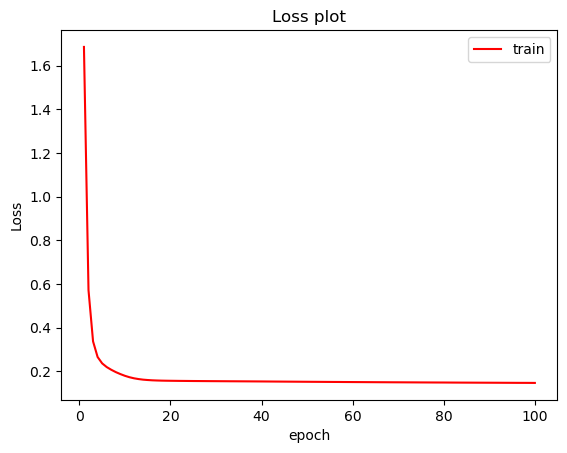

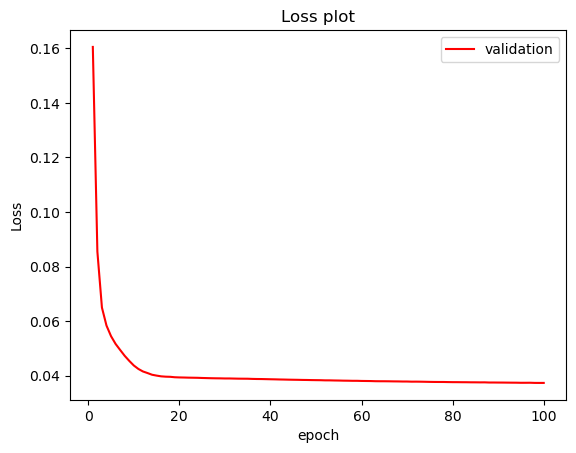

In [27]:
joint_model = train_the_model(joint_model, train_loader, val_loader, 'joint')
torch.save(joint_model, 'models/joint_model.pt')

Validation Loss: 0.0047: 100%|██████████| 68/68 [00:00<00:00, 450.49it/s]


Epoch 1 finished in 1.81s
[Epoch 1]	Train Loss: 2.824011	Validation Loss: 0.342262


Validation Loss: 0.0032: 100%|██████████| 68/68 [00:00<00:00, 354.40it/s]


Epoch 2 finished in 1.37s
[Epoch 2]	Train Loss: 1.474644	Validation Loss: 0.227592


Validation Loss: 0.0020: 100%|██████████| 68/68 [00:00<00:00, 420.03it/s]


Epoch 3 finished in 1.41s
[Epoch 3]	Train Loss: 0.991535	Validation Loss: 0.145043


Validation Loss: 0.0015: 100%|██████████| 68/68 [00:00<00:00, 401.32it/s]


Epoch 4 finished in 1.37s
[Epoch 4]	Train Loss: 0.703527	Validation Loss: 0.111950


Validation Loss: 0.0012: 100%|██████████| 68/68 [00:00<00:00, 410.61it/s]


Epoch 5 finished in 1.36s
[Epoch 5]	Train Loss: 0.525175	Validation Loss: 0.087085


Validation Loss: 0.0010: 100%|██████████| 68/68 [00:00<00:00, 409.48it/s]


Epoch 6 finished in 1.34s
[Epoch 6]	Train Loss: 0.416115	Validation Loss: 0.072368


Validation Loss: 0.0010: 100%|██████████| 68/68 [00:00<00:00, 396.11it/s]


Epoch 7 finished in 1.37s
[Epoch 7]	Train Loss: 0.349309	Validation Loss: 0.066531


Validation Loss: 0.0009: 100%|██████████| 68/68 [00:00<00:00, 415.39it/s]


Epoch 8 finished in 1.34s
[Epoch 8]	Train Loss: 0.307043	Validation Loss: 0.061244


Validation Loss: 0.0009: 100%|██████████| 68/68 [00:00<00:00, 417.76it/s]


Epoch 9 finished in 1.41s
[Epoch 9]	Train Loss: 0.279314	Validation Loss: 0.058990


Validation Loss: 0.0008: 100%|██████████| 68/68 [00:00<00:00, 413.12it/s]


Epoch 10 finished in 1.36s
[Epoch 10]	Train Loss: 0.258944	Validation Loss: 0.057005


Validation Loss: 0.0008: 100%|██████████| 68/68 [00:00<00:00, 422.88it/s]


Epoch 11 finished in 1.36s
[Epoch 11]	Train Loss: 0.244287	Validation Loss: 0.054635


Validation Loss: 0.0008: 100%|██████████| 68/68 [00:00<00:00, 375.42it/s]


Epoch 12 finished in 1.38s
[Epoch 12]	Train Loss: 0.231535	Validation Loss: 0.052750


Validation Loss: 0.0007: 100%|██████████| 68/68 [00:00<00:00, 444.98it/s]


Epoch 13 finished in 1.34s
[Epoch 13]	Train Loss: 0.220725	Validation Loss: 0.050856


Validation Loss: 0.0007: 100%|██████████| 68/68 [00:00<00:00, 409.71it/s]


Epoch 14 finished in 1.36s
[Epoch 14]	Train Loss: 0.210875	Validation Loss: 0.049083


Validation Loss: 0.0007: 100%|██████████| 68/68 [00:00<00:00, 328.65it/s]


Epoch 15 finished in 1.42s
[Epoch 15]	Train Loss: 0.202075	Validation Loss: 0.047244


Validation Loss: 0.0007: 100%|██████████| 68/68 [00:00<00:00, 408.36it/s]


Epoch 16 finished in 1.39s
[Epoch 16]	Train Loss: 0.194414	Validation Loss: 0.045744


Validation Loss: 0.0007: 100%|██████████| 68/68 [00:00<00:00, 418.54it/s]


Epoch 17 finished in 1.34s
[Epoch 17]	Train Loss: 0.187515	Validation Loss: 0.044313


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 441.38it/s]


Epoch 18 finished in 1.38s
[Epoch 18]	Train Loss: 0.181916	Validation Loss: 0.043291


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 433.03it/s]


Epoch 19 finished in 1.34s
[Epoch 19]	Train Loss: 0.176764	Validation Loss: 0.042401


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 404.34it/s]


Epoch 20 finished in 1.32s
[Epoch 20]	Train Loss: 0.172535	Validation Loss: 0.041661


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 386.90it/s]


Epoch 21 finished in 1.81s
[Epoch 21]	Train Loss: 0.169502	Validation Loss: 0.041164


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 425.72it/s]


Epoch 22 finished in 1.33s
[Epoch 22]	Train Loss: 0.166639	Validation Loss: 0.040644


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 442.70it/s]


Epoch 23 finished in 1.33s
[Epoch 23]	Train Loss: 0.164585	Validation Loss: 0.040265


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 407.15it/s]


Epoch 24 finished in 1.37s
[Epoch 24]	Train Loss: 0.162954	Validation Loss: 0.040083


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 399.25it/s]


Epoch 25 finished in 1.39s
[Epoch 25]	Train Loss: 0.161555	Validation Loss: 0.039832


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 389.13it/s]


Epoch 26 finished in 1.38s
[Epoch 26]	Train Loss: 0.160612	Validation Loss: 0.039720


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 427.55it/s]


Epoch 27 finished in 1.32s
[Epoch 27]	Train Loss: 0.159781	Validation Loss: 0.039556


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 421.56it/s]


Epoch 28 finished in 1.44s
[Epoch 28]	Train Loss: 0.159103	Validation Loss: 0.039504


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 402.55it/s]


Epoch 29 finished in 1.39s
[Epoch 29]	Train Loss: 0.158602	Validation Loss: 0.039397


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 416.89it/s]


Epoch 30 finished in 1.36s
[Epoch 30]	Train Loss: 0.158177	Validation Loss: 0.039374


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 400.31it/s]


Epoch 31 finished in 1.39s
[Epoch 31]	Train Loss: 0.157826	Validation Loss: 0.039331


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 430.25it/s]


Epoch 32 finished in 1.34s
[Epoch 32]	Train Loss: 0.157521	Validation Loss: 0.039241


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 412.73it/s]


Epoch 33 finished in 1.34s
[Epoch 33]	Train Loss: 0.157212	Validation Loss: 0.039243


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 342.10it/s]


Epoch 34 finished in 1.44s
[Epoch 34]	Train Loss: 0.156910	Validation Loss: 0.039139


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 424.11it/s]


Epoch 35 finished in 1.36s
[Epoch 35]	Train Loss: 0.156688	Validation Loss: 0.039132


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 415.50it/s]


Epoch 36 finished in 1.34s
[Epoch 36]	Train Loss: 0.156511	Validation Loss: 0.039082


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 436.78it/s]


Epoch 37 finished in 1.37s
[Epoch 37]	Train Loss: 0.156297	Validation Loss: 0.039052


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 430.53it/s]


Epoch 38 finished in 1.32s
[Epoch 38]	Train Loss: 0.156058	Validation Loss: 0.039020


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 416.46it/s]


Epoch 39 finished in 1.38s
[Epoch 39]	Train Loss: 0.155860	Validation Loss: 0.038991


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 423.34it/s]


Epoch 40 finished in 1.33s
[Epoch 40]	Train Loss: 0.155689	Validation Loss: 0.038939


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 305.99it/s]


Epoch 41 finished in 1.89s
[Epoch 41]	Train Loss: 0.155544	Validation Loss: 0.038918


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 429.81it/s]


Epoch 42 finished in 1.35s
[Epoch 42]	Train Loss: 0.155389	Validation Loss: 0.038870


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 416.08it/s]


Epoch 43 finished in 1.33s
[Epoch 43]	Train Loss: 0.155246	Validation Loss: 0.038848


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 394.97it/s]


Epoch 44 finished in 1.38s
[Epoch 44]	Train Loss: 0.155113	Validation Loss: 0.038817


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 422.51it/s]


Epoch 45 finished in 1.36s
[Epoch 45]	Train Loss: 0.155000	Validation Loss: 0.038808


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 382.60it/s]


Epoch 46 finished in 1.35s
[Epoch 46]	Train Loss: 0.154808	Validation Loss: 0.038759


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 415.42it/s]


Epoch 47 finished in 1.44s
[Epoch 47]	Train Loss: 0.154721	Validation Loss: 0.038754


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 438.25it/s]


Epoch 48 finished in 1.35s
[Epoch 48]	Train Loss: 0.154603	Validation Loss: 0.038737


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 395.44it/s]


Epoch 49 finished in 1.35s
[Epoch 49]	Train Loss: 0.154499	Validation Loss: 0.038706


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 420.90it/s]


Epoch 50 finished in 1.34s
[Epoch 50]	Train Loss: 0.154420	Validation Loss: 0.038696


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 435.03it/s]


Epoch 51 finished in 1.33s
[Epoch 51]	Train Loss: 0.154312	Validation Loss: 0.038671


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 433.69it/s]


Epoch 52 finished in 1.34s
[Epoch 52]	Train Loss: 0.154196	Validation Loss: 0.038643


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 346.87it/s]


Epoch 53 finished in 1.43s
[Epoch 53]	Train Loss: 0.154141	Validation Loss: 0.038626


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 435.93it/s]


Epoch 54 finished in 1.37s
[Epoch 54]	Train Loss: 0.154068	Validation Loss: 0.038624


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 393.66it/s]


Epoch 55 finished in 1.33s
[Epoch 55]	Train Loss: 0.153971	Validation Loss: 0.038591


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 429.64it/s]


Epoch 56 finished in 1.39s
[Epoch 56]	Train Loss: 0.153900	Validation Loss: 0.038571


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 413.71it/s]


Epoch 57 finished in 1.37s
[Epoch 57]	Train Loss: 0.153824	Validation Loss: 0.038553


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 424.84it/s]


Epoch 58 finished in 1.36s
[Epoch 58]	Train Loss: 0.153732	Validation Loss: 0.038551


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 425.28it/s]


Epoch 59 finished in 1.35s
[Epoch 59]	Train Loss: 0.153658	Validation Loss: 0.038529


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 396.77it/s]


Epoch 60 finished in 1.44s
[Epoch 60]	Train Loss: 0.153563	Validation Loss: 0.038518


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 280.65it/s]


Epoch 61 finished in 1.76s
[Epoch 61]	Train Loss: 0.153484	Validation Loss: 0.038520


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 423.37it/s]


Epoch 62 finished in 1.35s
[Epoch 62]	Train Loss: 0.153445	Validation Loss: 0.038477


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 431.05it/s]


Epoch 63 finished in 1.35s
[Epoch 63]	Train Loss: 0.153329	Validation Loss: 0.038455


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 407.51it/s]


Epoch 64 finished in 1.38s
[Epoch 64]	Train Loss: 0.153262	Validation Loss: 0.038443


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 414.65it/s]


Epoch 65 finished in 1.35s
[Epoch 65]	Train Loss: 0.153173	Validation Loss: 0.038435


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 444.87it/s]


Epoch 66 finished in 1.42s
[Epoch 66]	Train Loss: 0.153052	Validation Loss: 0.038406


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 417.76it/s]


Epoch 67 finished in 1.34s
[Epoch 67]	Train Loss: 0.153015	Validation Loss: 0.038402


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 421.01it/s]


Epoch 68 finished in 1.35s
[Epoch 68]	Train Loss: 0.152952	Validation Loss: 0.038372


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 414.98it/s]


Epoch 69 finished in 1.34s
[Epoch 69]	Train Loss: 0.152926	Validation Loss: 0.038377


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 424.45it/s]


Epoch 70 finished in 1.35s
[Epoch 70]	Train Loss: 0.152810	Validation Loss: 0.038340


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 438.15it/s]


Epoch 71 finished in 1.34s
[Epoch 71]	Train Loss: 0.152741	Validation Loss: 0.038327


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 422.94it/s]


Epoch 72 finished in 1.41s
[Epoch 72]	Train Loss: 0.152687	Validation Loss: 0.038305


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 430.64it/s]


Epoch 73 finished in 1.34s
[Epoch 73]	Train Loss: 0.152583	Validation Loss: 0.038305


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 430.68it/s]


Epoch 74 finished in 1.34s
[Epoch 74]	Train Loss: 0.152537	Validation Loss: 0.038279


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 386.22it/s]


Epoch 75 finished in 1.42s
[Epoch 75]	Train Loss: 0.152474	Validation Loss: 0.038272


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 391.49it/s]


Epoch 76 finished in 1.38s
[Epoch 76]	Train Loss: 0.152407	Validation Loss: 0.038251


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 417.08it/s]


Epoch 77 finished in 1.33s
[Epoch 77]	Train Loss: 0.152320	Validation Loss: 0.038238


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 423.04it/s]


Epoch 78 finished in 1.35s
[Epoch 78]	Train Loss: 0.152244	Validation Loss: 0.038221


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 384.66it/s]


Epoch 79 finished in 1.42s
[Epoch 79]	Train Loss: 0.152232	Validation Loss: 0.038198


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 438.61it/s]


Epoch 80 finished in 1.34s
[Epoch 80]	Train Loss: 0.152120	Validation Loss: 0.038194


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 277.73it/s]


Epoch 81 finished in 1.74s
[Epoch 81]	Train Loss: 0.152074	Validation Loss: 0.038171


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 418.16it/s]


Epoch 82 finished in 1.39s
[Epoch 82]	Train Loss: 0.151961	Validation Loss: 0.038169


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 408.53it/s]


Epoch 83 finished in 1.38s
[Epoch 83]	Train Loss: 0.151970	Validation Loss: 0.038160


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 418.68it/s]


Epoch 84 finished in 1.35s
[Epoch 84]	Train Loss: 0.151878	Validation Loss: 0.038134


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 399.30it/s]


Epoch 85 finished in 1.40s
[Epoch 85]	Train Loss: 0.151827	Validation Loss: 0.038126


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 420.15it/s]


Epoch 86 finished in 1.35s
[Epoch 86]	Train Loss: 0.151789	Validation Loss: 0.038117


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 431.39it/s]


Epoch 87 finished in 1.35s
[Epoch 87]	Train Loss: 0.151685	Validation Loss: 0.038102


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 421.26it/s]


Epoch 88 finished in 1.34s
[Epoch 88]	Train Loss: 0.151562	Validation Loss: 0.038083


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 427.22it/s]


Epoch 89 finished in 1.37s
[Epoch 89]	Train Loss: 0.151550	Validation Loss: 0.038064


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 436.21it/s]


Epoch 90 finished in 1.35s
[Epoch 90]	Train Loss: 0.151462	Validation Loss: 0.038060


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 410.56it/s]


Epoch 91 finished in 1.41s
[Epoch 91]	Train Loss: 0.151452	Validation Loss: 0.038028


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 440.79it/s]


Epoch 92 finished in 1.35s
[Epoch 92]	Train Loss: 0.151373	Validation Loss: 0.038024


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 423.67it/s]


Epoch 93 finished in 1.34s
[Epoch 93]	Train Loss: 0.151280	Validation Loss: 0.038025


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 426.09it/s]


Epoch 94 finished in 1.35s
[Epoch 94]	Train Loss: 0.151241	Validation Loss: 0.038010


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 427.11it/s]


Epoch 95 finished in 1.33s
[Epoch 95]	Train Loss: 0.151180	Validation Loss: 0.037984


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 418.62it/s]


Epoch 96 finished in 1.41s
[Epoch 96]	Train Loss: 0.151086	Validation Loss: 0.037970


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 419.37it/s]


Epoch 97 finished in 1.35s
[Epoch 97]	Train Loss: 0.151041	Validation Loss: 0.037978


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 420.74it/s]


Epoch 98 finished in 1.41s
[Epoch 98]	Train Loss: 0.150985	Validation Loss: 0.037957


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 450.55it/s]


Epoch 99 finished in 1.35s
[Epoch 99]	Train Loss: 0.150947	Validation Loss: 0.037937


Validation Loss: 0.0005: 100%|██████████| 68/68 [00:00<00:00, 434.22it/s]


Epoch 100 finished in 1.35s
[Epoch 100]	Train Loss: 0.150865	Validation Loss: 0.037920


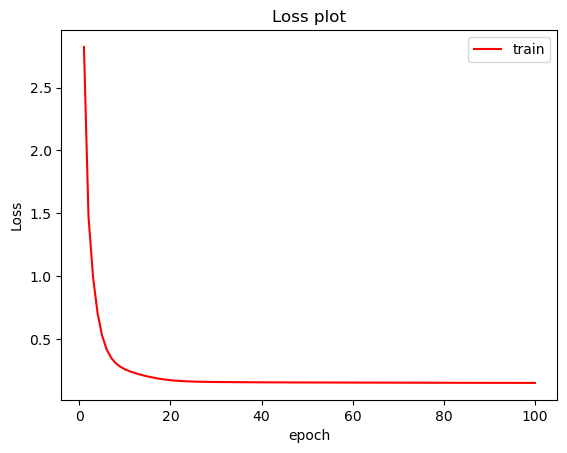

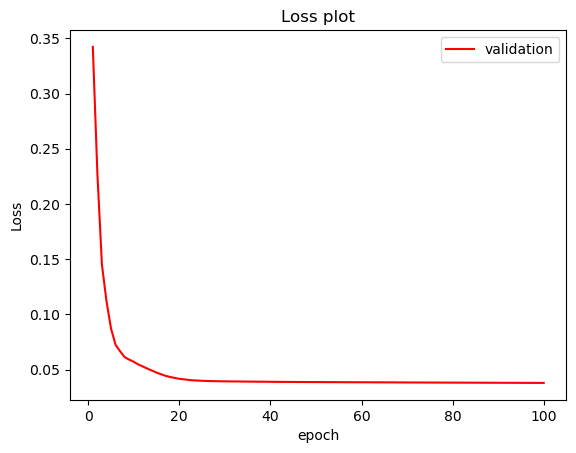

In [28]:
audio_text_model = train_the_model(audio_text_model, train_loader, val_loader, 'audio')
torch.save(audio_text_model, 'models/audio_text_model.pt')

Validation Loss: 0.0044: 100%|██████████| 68/68 [00:00<00:00, 371.42it/s]


Epoch 1 finished in 1.85s
[Epoch 1]	Train Loss: 2.692977	Validation Loss: 0.283574


Validation Loss: 0.0025: 100%|██████████| 68/68 [00:00<00:00, 391.03it/s]


Epoch 2 finished in 1.40s
[Epoch 2]	Train Loss: 1.352662	Validation Loss: 0.168094


Validation Loss: 0.0017: 100%|██████████| 68/68 [00:00<00:00, 313.94it/s]


Epoch 3 finished in 1.46s
[Epoch 3]	Train Loss: 0.887783	Validation Loss: 0.116637


Validation Loss: 0.0013: 100%|██████████| 68/68 [00:00<00:00, 392.91it/s]


Epoch 4 finished in 1.40s
[Epoch 4]	Train Loss: 0.629232	Validation Loss: 0.088774


Validation Loss: 0.0010: 100%|██████████| 68/68 [00:00<00:00, 418.84it/s]


Epoch 5 finished in 1.36s
[Epoch 5]	Train Loss: 0.476986	Validation Loss: 0.073715


Validation Loss: 0.0010: 100%|██████████| 68/68 [00:00<00:00, 406.82it/s]


Epoch 6 finished in 1.36s
[Epoch 6]	Train Loss: 0.383921	Validation Loss: 0.066219


Validation Loss: 0.0009: 100%|██████████| 68/68 [00:00<00:00, 422.24it/s]


Epoch 7 finished in 1.37s
[Epoch 7]	Train Loss: 0.328531	Validation Loss: 0.062095


Validation Loss: 0.0009: 100%|██████████| 68/68 [00:00<00:00, 371.66it/s]


Epoch 8 finished in 1.40s
[Epoch 8]	Train Loss: 0.292746	Validation Loss: 0.059338


Validation Loss: 0.0008: 100%|██████████| 68/68 [00:00<00:00, 432.61it/s]


Epoch 9 finished in 1.35s
[Epoch 9]	Train Loss: 0.269305	Validation Loss: 0.057157


Validation Loss: 0.0008: 100%|██████████| 68/68 [00:00<00:00, 433.36it/s]


Epoch 10 finished in 1.41s
[Epoch 10]	Train Loss: 0.251352	Validation Loss: 0.055251


Validation Loss: 0.0008: 100%|██████████| 68/68 [00:00<00:00, 383.21it/s]


Epoch 11 finished in 1.42s
[Epoch 11]	Train Loss: 0.237763	Validation Loss: 0.053498


Validation Loss: 0.0008: 100%|██████████| 68/68 [00:00<00:00, 384.78it/s]


Epoch 12 finished in 1.39s
[Epoch 12]	Train Loss: 0.226413	Validation Loss: 0.051799


Validation Loss: 0.0007: 100%|██████████| 68/68 [00:00<00:00, 423.05it/s]


Epoch 13 finished in 1.35s
[Epoch 13]	Train Loss: 0.216217	Validation Loss: 0.050119


Validation Loss: 0.0007: 100%|██████████| 68/68 [00:00<00:00, 413.29it/s]


Epoch 14 finished in 1.36s
[Epoch 14]	Train Loss: 0.207478	Validation Loss: 0.048563


Validation Loss: 0.0007: 100%|██████████| 68/68 [00:00<00:00, 426.25it/s]


Epoch 15 finished in 1.37s
[Epoch 15]	Train Loss: 0.199390	Validation Loss: 0.046992


Validation Loss: 0.0007: 100%|██████████| 68/68 [00:00<00:00, 405.27it/s]


Epoch 16 finished in 1.46s
[Epoch 16]	Train Loss: 0.192204	Validation Loss: 0.045689


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 403.39it/s]


Epoch 17 finished in 1.36s
[Epoch 17]	Train Loss: 0.185604	Validation Loss: 0.044332


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 395.42it/s]


Epoch 18 finished in 1.39s
[Epoch 18]	Train Loss: 0.179947	Validation Loss: 0.043200


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 401.42it/s]


Epoch 19 finished in 1.36s
[Epoch 19]	Train Loss: 0.175197	Validation Loss: 0.042326


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 417.36it/s]


Epoch 20 finished in 1.39s
[Epoch 20]	Train Loss: 0.171044	Validation Loss: 0.041557


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 390.88it/s]


Epoch 21 finished in 1.72s
[Epoch 21]	Train Loss: 0.167665	Validation Loss: 0.040999


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 401.29it/s]


Epoch 22 finished in 1.48s
[Epoch 22]	Train Loss: 0.165098	Validation Loss: 0.040521


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 427.43it/s]


Epoch 23 finished in 1.38s
[Epoch 23]	Train Loss: 0.162982	Validation Loss: 0.040164


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 400.09it/s]


Epoch 24 finished in 1.36s
[Epoch 24]	Train Loss: 0.161497	Validation Loss: 0.039939


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 434.43it/s]


Epoch 25 finished in 1.37s
[Epoch 25]	Train Loss: 0.160291	Validation Loss: 0.039752


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 391.87it/s]


Epoch 26 finished in 1.37s
[Epoch 26]	Train Loss: 0.159328	Validation Loss: 0.039622


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 396.40it/s]


Epoch 27 finished in 1.40s
[Epoch 27]	Train Loss: 0.158670	Validation Loss: 0.039524


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 340.12it/s]


Epoch 28 finished in 1.42s
[Epoch 28]	Train Loss: 0.158065	Validation Loss: 0.039438


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 430.48it/s]


Epoch 29 finished in 1.38s
[Epoch 29]	Train Loss: 0.157654	Validation Loss: 0.039388


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 422.18it/s]


Epoch 30 finished in 1.36s
[Epoch 30]	Train Loss: 0.157241	Validation Loss: 0.039318


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 420.68it/s]


Epoch 31 finished in 1.39s
[Epoch 31]	Train Loss: 0.156930	Validation Loss: 0.039277


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 429.98it/s]


Epoch 32 finished in 1.39s
[Epoch 32]	Train Loss: 0.156679	Validation Loss: 0.039254


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 407.78it/s]


Epoch 33 finished in 1.38s
[Epoch 33]	Train Loss: 0.156560	Validation Loss: 0.039222


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 424.55it/s]


Epoch 34 finished in 1.37s
[Epoch 34]	Train Loss: 0.156365	Validation Loss: 0.039205


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 403.99it/s]


Epoch 35 finished in 1.45s
[Epoch 35]	Train Loss: 0.156305	Validation Loss: 0.039194


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 407.05it/s]


Epoch 36 finished in 1.38s
[Epoch 36]	Train Loss: 0.156191	Validation Loss: 0.039185


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 428.95it/s]


Epoch 37 finished in 1.34s
[Epoch 37]	Train Loss: 0.156126	Validation Loss: 0.039169


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 396.51it/s]


Epoch 38 finished in 1.42s
[Epoch 38]	Train Loss: 0.156081	Validation Loss: 0.039165


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 421.00it/s]


Epoch 39 finished in 1.42s
[Epoch 39]	Train Loss: 0.156021	Validation Loss: 0.039159


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 261.13it/s]


Epoch 40 finished in 1.54s
[Epoch 40]	Train Loss: 0.155967	Validation Loss: 0.039150


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 395.95it/s]


Epoch 41 finished in 1.72s
[Epoch 41]	Train Loss: 0.155923	Validation Loss: 0.039143


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 437.73it/s]


Epoch 42 finished in 1.36s
[Epoch 42]	Train Loss: 0.155876	Validation Loss: 0.039143


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 405.63it/s]


Epoch 43 finished in 1.39s
[Epoch 43]	Train Loss: 0.155835	Validation Loss: 0.039139


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 408.64it/s]


Epoch 44 finished in 1.35s
[Epoch 44]	Train Loss: 0.155825	Validation Loss: 0.039135


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 399.71it/s]


Epoch 45 finished in 1.37s
[Epoch 45]	Train Loss: 0.155808	Validation Loss: 0.039131


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 402.83it/s]


Epoch 46 finished in 1.37s
[Epoch 46]	Train Loss: 0.155787	Validation Loss: 0.039134


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 401.79it/s]


Epoch 47 finished in 1.44s
[Epoch 47]	Train Loss: 0.155763	Validation Loss: 0.039128


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 450.56it/s]


Epoch 48 finished in 1.35s
[Epoch 48]	Train Loss: 0.155735	Validation Loss: 0.039126


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 426.30it/s]


Epoch 49 finished in 1.33s
[Epoch 49]	Train Loss: 0.155690	Validation Loss: 0.039125


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 411.08it/s]


Epoch 50 finished in 1.37s
[Epoch 50]	Train Loss: 0.155702	Validation Loss: 0.039126


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 399.73it/s]


Epoch 51 finished in 1.36s
[Epoch 51]	Train Loss: 0.155697	Validation Loss: 0.039125


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 418.11it/s]


Epoch 52 finished in 1.36s
[Epoch 52]	Train Loss: 0.155663	Validation Loss: 0.039122


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 343.94it/s]


Epoch 53 finished in 1.41s
[Epoch 53]	Train Loss: 0.155640	Validation Loss: 0.039126


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 392.19it/s]


Epoch 54 finished in 1.42s
[Epoch 54]	Train Loss: 0.155624	Validation Loss: 0.039118


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 416.53it/s]


Epoch 55 finished in 1.39s
[Epoch 55]	Train Loss: 0.155618	Validation Loss: 0.039117


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 410.33it/s]


Epoch 56 finished in 1.35s
[Epoch 56]	Train Loss: 0.155607	Validation Loss: 0.039118


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 417.56it/s]


Epoch 57 finished in 1.39s
[Epoch 57]	Train Loss: 0.155601	Validation Loss: 0.039116


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 394.60it/s]


Epoch 58 finished in 1.36s
[Epoch 58]	Train Loss: 0.155589	Validation Loss: 0.039118


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 416.37it/s]


Epoch 59 finished in 1.37s
[Epoch 59]	Train Loss: 0.155567	Validation Loss: 0.039119


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 249.73it/s]


Epoch 60 finished in 1.63s
[Epoch 60]	Train Loss: 0.155571	Validation Loss: 0.039119


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 436.26it/s]


Epoch 61 finished in 1.53s
[Epoch 61]	Train Loss: 0.155547	Validation Loss: 0.039117


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 397.04it/s]


Epoch 62 finished in 1.43s
[Epoch 62]	Train Loss: 0.155551	Validation Loss: 0.039120


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 419.13it/s]


Epoch 63 finished in 1.37s
[Epoch 63]	Train Loss: 0.155533	Validation Loss: 0.039116


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 421.35it/s]


Epoch 64 finished in 1.37s
[Epoch 64]	Train Loss: 0.155531	Validation Loss: 0.039113


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 397.07it/s]


Epoch 65 finished in 1.37s
[Epoch 65]	Train Loss: 0.155527	Validation Loss: 0.039117


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 398.83it/s]


Epoch 66 finished in 1.46s
[Epoch 66]	Train Loss: 0.155519	Validation Loss: 0.039115


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 410.25it/s]


Epoch 67 finished in 1.38s
[Epoch 67]	Train Loss: 0.155498	Validation Loss: 0.039120


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 402.12it/s]


Epoch 68 finished in 1.37s
[Epoch 68]	Train Loss: 0.155498	Validation Loss: 0.039119


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 400.18it/s]


Epoch 69 finished in 1.36s
[Epoch 69]	Train Loss: 0.155487	Validation Loss: 0.039116


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 411.17it/s]


Epoch 70 finished in 1.37s
[Epoch 70]	Train Loss: 0.155471	Validation Loss: 0.039116


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 399.01it/s]


Epoch 71 finished in 1.38s
[Epoch 71]	Train Loss: 0.155465	Validation Loss: 0.039118


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 422.52it/s]


Epoch 72 finished in 1.40s
[Epoch 72]	Train Loss: 0.155457	Validation Loss: 0.039115


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 415.91it/s]


Epoch 73 finished in 1.36s
[Epoch 73]	Train Loss: 0.155455	Validation Loss: 0.039117


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 421.60it/s]


Epoch 74 finished in 1.37s
[Epoch 74]	Train Loss: 0.155457	Validation Loss: 0.039116


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 418.68it/s]


Epoch 75 finished in 1.37s
[Epoch 75]	Train Loss: 0.155436	Validation Loss: 0.039116


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 407.61it/s]


Epoch 76 finished in 1.35s
[Epoch 76]	Train Loss: 0.155429	Validation Loss: 0.039115


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 396.13it/s]


Epoch 77 finished in 1.39s
[Epoch 77]	Train Loss: 0.155424	Validation Loss: 0.039116


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 437.09it/s]


Epoch 78 finished in 1.36s
[Epoch 78]	Train Loss: 0.155425	Validation Loss: 0.039116


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 405.54it/s]


Epoch 79 finished in 1.40s
[Epoch 79]	Train Loss: 0.155417	Validation Loss: 0.039116


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 258.43it/s]


Epoch 80 finished in 1.61s
[Epoch 80]	Train Loss: 0.155407	Validation Loss: 0.039117


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 394.96it/s]


Epoch 81 finished in 1.46s
[Epoch 81]	Train Loss: 0.155415	Validation Loss: 0.039117


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 433.45it/s]


Epoch 82 finished in 1.36s
[Epoch 82]	Train Loss: 0.155405	Validation Loss: 0.039117


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 404.43it/s]


Epoch 83 finished in 1.38s
[Epoch 83]	Train Loss: 0.155398	Validation Loss: 0.039118


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 397.58it/s]


Epoch 84 finished in 1.38s
[Epoch 84]	Train Loss: 0.155389	Validation Loss: 0.039119


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 395.60it/s]


Epoch 85 finished in 1.38s
[Epoch 85]	Train Loss: 0.155376	Validation Loss: 0.039117


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 405.20it/s]


Epoch 86 finished in 1.35s
[Epoch 86]	Train Loss: 0.155384	Validation Loss: 0.039118


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 415.05it/s]


Epoch 87 finished in 1.38s
[Epoch 87]	Train Loss: 0.155361	Validation Loss: 0.039121


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 408.50it/s]


Epoch 88 finished in 1.38s
[Epoch 88]	Train Loss: 0.155361	Validation Loss: 0.039117


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 403.90it/s]


Epoch 89 finished in 1.38s
[Epoch 89]	Train Loss: 0.155367	Validation Loss: 0.039117


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 411.33it/s]


Epoch 90 finished in 1.34s
[Epoch 90]	Train Loss: 0.155351	Validation Loss: 0.039119


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 414.34it/s]


Epoch 91 finished in 1.46s
[Epoch 91]	Train Loss: 0.155350	Validation Loss: 0.039117


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 426.94it/s]


Epoch 92 finished in 1.35s
[Epoch 92]	Train Loss: 0.155339	Validation Loss: 0.039118


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 370.47it/s]


Epoch 93 finished in 1.40s
[Epoch 93]	Train Loss: 0.155339	Validation Loss: 0.039118


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 394.42it/s]


Epoch 94 finished in 1.38s
[Epoch 94]	Train Loss: 0.155329	Validation Loss: 0.039119


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 395.98it/s]


Epoch 95 finished in 1.41s
[Epoch 95]	Train Loss: 0.155327	Validation Loss: 0.039118


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 396.70it/s]


Epoch 96 finished in 1.36s
[Epoch 96]	Train Loss: 0.155330	Validation Loss: 0.039118


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 414.91it/s]


Epoch 97 finished in 1.42s
[Epoch 97]	Train Loss: 0.155316	Validation Loss: 0.039121


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 389.90it/s]


Epoch 98 finished in 1.40s
[Epoch 98]	Train Loss: 0.155310	Validation Loss: 0.039119


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 413.59it/s]


Epoch 99 finished in 1.38s
[Epoch 99]	Train Loss: 0.155304	Validation Loss: 0.039121


Validation Loss: 0.0006: 100%|██████████| 68/68 [00:00<00:00, 365.99it/s]


Epoch 100 finished in 1.62s
[Epoch 100]	Train Loss: 0.155303	Validation Loss: 0.039121


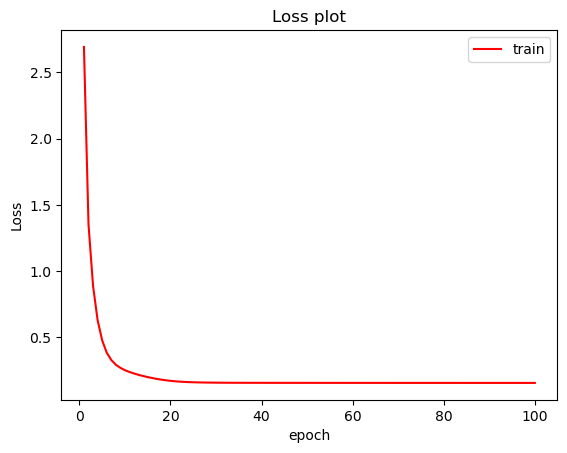

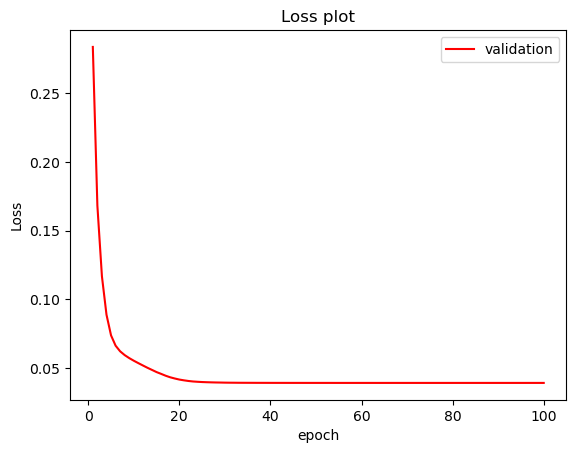

In [29]:
image_text_model = train_the_model(image_text_model, train_loader, val_loader, 'image')
torch.save(image_text_model, 'models/image_text_model.pt')

# Evaluation

In [30]:
_test_dataset = {'text':text_embedding_test, 'image': image_embedding_test, 'audio': audio_embedding_test}

In [31]:
test_len_data = len(text_embedding_test)

number_of_candidates_per_sample = 5
test_metadata = []

for index in range(test_len_data):
    candidate_indexes = random.sample([i for i in range(test_len_data) if i != index], number_of_candidates_per_sample - 1)
    candidate_indexes += [index]
    test_metadata.append(candidate_indexes)
len(test_metadata)

1083

In [32]:
class TestDataset(Dataset):
    def __init__(self, test_dataset, metadata):
        self.data = test_dataset
        self.metadata = metadata

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        candidate_indexes = self.metadata[index]
        text_embedding = self.data['text'][index]
        audio_embeddings = [self.data['audio'][i] for i in candidate_indexes]
        image_embeddings = [self.data['image'][i] for i in candidate_indexes]
        label_index = 4
        audio_embeddings = torch.stack(audio_embeddings)
        image_embeddings = torch.stack(image_embeddings)

        return text_embedding, audio_embeddings, image_embeddings, label_index

In [33]:
test_dataset = TestDataset(_test_dataset, test_metadata)
test_final_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

In [34]:
def evaluate(model_path, mode='joint'):
    model = torch.load(model_path)
    model.eval()
    model = model.to(device)

    def compute_cosine_similarity(embedding1: torch.Tensor, embedding2: torch.Tensor) -> float:
        similarity = cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0)).item()
        return similarity

    def cosine_similarity(embedding1, embedding2):
        dim = 1
        embedding1 = F.normalize(embedding1, p=2, dim=dim)
        embedding2 = F.normalize(embedding2, p=2, dim=dim)

        dot_product = torch.sum(embedding1 * embedding2, dim=dim)

        magnitude1 = torch.norm(embedding1, p=2, dim=dim)
        magnitude2 = torch.norm(embedding2, p=2, dim=dim)

        cosine_sim = dot_product / (magnitude1 * magnitude2)

        return cosine_sim
    
    def _evaluate(model, dataloader, threshold=0.5, mode='joint'):
        total_hits_1 = 0
        total_mrr = 0
        total_instances = 0
        total_labels = []
        total_predictions = []
        number_of_golden_predictions = 0

        with torch.no_grad():
            for text_embedding, audio_candidates, image_candidates, label in tqdm(dataloader):
                label = label[0]
                text_embedding = text_embedding[0].to(device)
                label = label.to(device)

                if mode == 'joint':   
                    audio_candidates = audio_candidates[0]
                    audio_candidates = audio_candidates.to(device)
                    
                    image_candidates = image_candidates[0]
                    image_candidates = image_candidates.to(device)
                    final_embs = model(audio_candidates, image_candidates)
                elif mode == 'audio':
                    audio_candidates = audio_candidates[0]
                    audio_candidates = audio_candidates.to(device)
                    final_embs = model(audio_candidates)
                elif mode == 'image':
                    image_candidates = image_candidates[0]
                    image_candidates = image_candidates.to(device)
                    final_embs = model(image_candidates)    
                
                text_candidate_cosine_similarities = [compute_cosine_similarity(text_embedding, item) for item in final_embs]
                predicted_idx = np.argmax(text_candidate_cosine_similarities)
                
                label_similarity = text_candidate_cosine_similarities[label.item()]

                # Compute Hits@1
                if predicted_idx == label.item():   
                    total_hits_1 += 1

                # Compute MRR
                label_rank = sum([1 for x in text_candidate_cosine_similarities if x > text_candidate_cosine_similarities[label.item()]])
                reciprocal_rank = 1 / (label_rank + 1)
                total_mrr += reciprocal_rank

                # Record predictions and labels
                predictions = [0 if sim < threshold else 1 for sim in text_candidate_cosine_similarities]
                total_labels.extend([0 if i != label.item() else 1 for i in range(len(text_candidate_cosine_similarities))])
                total_predictions.extend(predictions)
                if label_similarity >= threshold:
                    number_of_golden_predictions += 1

                total_instances += 1

        # Compute average metrics over all instances
        avg_hits_1 = total_hits_1 / total_instances
        avg_mrr = total_mrr / total_instances
        precision = precision_score(total_labels, total_predictions, average='macro')
        recall = recall_score(total_labels, total_predictions, average='macro')
        f1 = f1_score(total_labels, total_predictions, average='macro')
        precision_micro = precision_score(total_labels, total_predictions, average='micro')
        recall_micro = recall_score(total_labels, total_predictions, average='micro')
        f1_micro = f1_score(total_labels, total_predictions, average='micro')
        accuracy = accuracy_score(total_labels, total_predictions)
        golden_prediction_accuracy = number_of_golden_predictions / total_instances

        return {
            'Hits@1': avg_hits_1,
            'MRR': avg_mrr,
            'Macro Precision': precision,
            'Macro Recall': recall,
            'Macro F1': f1,
            'Micro Precision': precision_micro,
            'Micro Recall': recall_micro,
            'Micro F1': f1_micro,
            'Accuracy': accuracy,
            'Golden Accuracy': golden_prediction_accuracy,
        }
    
    results = _evaluate(model, test_final_loader, threshold=0.2, mode=mode)
    table = []
    for i in range(len(results)):
        table.append([list(results.keys())[i], list(results.values())[i]])
    print(tabulate(table, ['Metrics', 'Values'], tablefmt="grid"))


In [35]:
evaluate('models/joint_model.pt', mode='joint')

100%|██████████| 1083/1083 [00:02<00:00, 395.77it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.806094 |
+-----------------+----------+
| MRR             | 0.892536 |
+-----------------+----------+
| Macro Precision | 0.590762 |
+-----------------+----------+
| Macro Recall    | 0.562211 |
+-----------------+----------+
| Macro F1        | 0.311217 |
+-----------------+----------+
| Micro Precision | 0.315051 |
+-----------------+----------+
| Micro Recall    | 0.315051 |
+-----------------+----------+
| Micro F1        | 0.315051 |
+-----------------+----------+
| Accuracy        | 0.315051 |
+-----------------+----------+
| Golden Accuracy | 0.974146 |
+-----------------+----------+


In [36]:
evaluate('models/audio_text_model.pt', mode='audio')

100%|██████████| 1083/1083 [00:01<00:00, 543.99it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.706371 |
+-----------------+----------+
| MRR             | 0.832579 |
+-----------------+----------+
| Macro Precision | 0.564536 |
+-----------------+----------+
| Macro Recall    | 0.537281 |
+-----------------+----------+
| Macro F1        | 0.27891  |
+-----------------+----------+
| Micro Precision | 0.285688 |
+-----------------+----------+
| Micro Recall    | 0.285688 |
+-----------------+----------+
| Micro F1        | 0.285688 |
+-----------------+----------+
| Accuracy        | 0.285688 |
+-----------------+----------+
| Golden Accuracy | 0.956602 |
+-----------------+----------+


In [37]:
evaluate('models/image_text_model.pt', mode='image')

100%|██████████| 1083/1083 [00:02<00:00, 491.17it/s]


+-----------------+----------+
| Metrics         |   Values |
+=================+==========+
| Hits@1          | 0.187442 |
+-----------------+----------+
| MRR             | 0.448954 |
+-----------------+----------+
| Macro Precision | 0.5      |
+-----------------+----------+
| Macro Recall    | 0.5      |
+-----------------+----------+
| Macro F1        | 0.225333 |
+-----------------+----------+
| Micro Precision | 0.239335 |
+-----------------+----------+
| Micro Recall    | 0.239335 |
+-----------------+----------+
| Micro F1        | 0.239335 |
+-----------------+----------+
| Accuracy        | 0.239335 |
+-----------------+----------+
| Golden Accuracy | 0.934441 |
+-----------------+----------+
